In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
from glob import glob

import numpy as np
import pandas as pd
from tqdm import tqdm

from dateutil.relativedelta import relativedelta

from common.utils import median_ensemble

In [2]:
from common.summary_utils import EnsembleStatistics
from common.metrics import smape_1, smape_2, nd, mape

# M3
from resources.m3.dataset import M3Dataset, M3Meta
from resources.m3.evaluator import M3Evaluator

class M3Statistics:
    def __init__(self, **args):
        self.training, self.target = M3Dataset(M3Meta.dataset_path).standard_split()
        self.evaluator = M3Evaluator(self.target, **args)
        
    def evaluate(self, predictions):
        return self.evaluator.evaluate(self.training.future_values([p[~np.isnan(p)] for p in predictions]))
    
# TOURISM
from resources.tourism.dataset import TourismDataset, TourismMeta
from resources.tourism.evaluator import TourismEvaluator

class TourismStatistics:
    def __init__(self, **args):
        self.training, self.target = TourismDataset(TourismMeta.dataset_path).standard_split()
        self.evaluator = TourismEvaluator(self.target, **args)
        
    def evaluate(self, predictions):
        return self.evaluator.evaluate(self.training.future_values([p[~np.isnan(p)] for p in predictions]))
    
# ELECTRICITY
from resources.electricity.dataset import ElectricityDataset, ElectricityMeta
from resources.electricity.evaluator import ElectricityEvaluator

class ElectricityStatistics:
    def __init__(self, **args):
        self.training, self.target = ElectricityDataset(ElectricityMeta.dataset_path).load_cache().split(
            lambda ts: ts.split_by_time(ElectricityMeta.deepar_split))
        self.target, _ = self.target.split(lambda ts: ts.split(24 * 7))
        self.evaluator = ElectricityEvaluator(self.target, precision=5, **args)
        
    def evaluate(self, predictions):
        return self.evaluator.evaluate(self.training.future_values([p[~np.isnan(p)] for p in predictions]))
    
# TRAFFIC
from resources.traffic.dataset import TrafficDataset, TrafficMeta
from resources.traffic.evaluator import TrafficEvaluator

class TrafficStatistics:
    def __init__(self, **args):
        self.training, self.target = TrafficDataset(TrafficMeta.dataset_path).load_cache().split(
            lambda ts: ts.split_by_time(TrafficMeta.deepar_split))
        self.target, _ = self.target.split(lambda ts: ts.split(24 * 7))
        self.evaluator = TrafficEvaluator(self.target, precision=5, **args)
        
    def evaluate(self, predictions):
        return self.evaluator.evaluate(self.training.future_values([p[~np.isnan(p)] for p in predictions]))
    
def collect_statistics(filter_path, evaluator):
    statistics = EnsembleStatistics(filter_path=filter_path, evaluator=evaluator)

    bootstrap = statistics.bootstrap(ensemble_keys=['repeats', 'lookback_period', 'loss_name'], 
                                     bootstrap_key='repeats', 
                                     bootstrap_size=5, 
                                     number_of_samples=100)

    bootstrap['width'] = pd.to_numeric(bootstrap['width'])
    bootstrap['blocks'] = pd.to_numeric(bootstrap['blocks'])
    bootstrap['stacks'] = pd.to_numeric(bootstrap['stacks'])
    bootstrap['metric'] = pd.to_numeric(bootstrap['metric'])
    
    return bootstrap

# FRED
from resources.fred.dataset import FredDataset, FredMeta
from resources.fred.evaluator import FredEvaluator

class FredStatistics:
    def __init__(self, **args):
        self.training, self.target = FredDataset(FredMeta.dataset_path).standard_split()
        self.evaluator = FredEvaluator(self.target, **args)
        
    def evaluate(self, predictions):
        return self.evaluator.evaluate(self.training.future_values([p[~np.isnan(p)] for p in predictions]))

#
# PLOTS
#
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='notebook', style='white', font_scale=1.2, rc={'xtick.bottom':True, 'ytick.left':True, 'font.family':['serif']})
# sns.set(font='Times New Roman')

def plot_summary(results, result_column, eval_key, metric_name, baseline, plots_path):
    pd.options.mode.chained_assignment = None  # default='warn'
    blocks = results[(results.stacks == 1) & (results.evaluation_key == eval_key)]
    stacks = results[(results['blocks'] == 1) & (results.evaluation_key == eval_key)]

    blocks_avg = blocks[[result_column]]
    blocks_avg.loc[:, ('n')] = blocks['blocks']
    blocks_avg.loc[:, ('agg_type')] = 'True'

    stacks_avg = stacks[[result_column]]
    stacks_avg.loc[:, ('n')] = stacks['stacks']
    stacks_avg.loc[:, ('agg_type')] = 'False'

    blocks_stacks = pd.concat([blocks_avg, stacks_avg])

    ax = sns.lineplot(x='n', y='metric', hue='agg_type', data=blocks_stacks, ci='sd')
    ax.set(xlabel='Number of Blocks', ylabel=metric_name)
    if baseline is not None:
        ax.axhline(baseline, ls='--')
    plt.legend(title='Shared Weights', labels=['True', 'False'])
    plt.show()
    if plots_path is not None:
        ax.get_figure().savefig(f'{plots_path}_{eval_key}_{metric_name}.pdf',bbox_inches='tight')

In [3]:
s_experiment_path = '/project/experiments/nbeats_meta/shared_grid_512'
ns_experiment_path = '/project/experiments/nbeats_meta/not_shared_grid_512'

# M3
m3_s_bootstrap = collect_statistics(f'{s_experiment_path}/**/M3.csv', M3Statistics())
m3_ns_bootstrap = collect_statistics(f'{ns_experiment_path}/**/M3.csv', M3Statistics())
m3_bootstrap = pd.concat([m3_s_bootstrap, m3_ns_bootstrap])

# Tourism
tourism_s_bootstrap = collect_statistics(f'{s_experiment_path}/**/tourism.csv', TourismStatistics())
tourism_ns_bootstrap = collect_statistics(f'{ns_experiment_path}/**/tourism.csv', TourismStatistics())
tourism_bootstrap = pd.concat([tourism_s_bootstrap, tourism_ns_bootstrap])

# Electricity
electricity_s_bootstrap = collect_statistics(f'{s_experiment_path}/**/electricity_deepar.csv', ElectricityStatistics())
electricity_ns_bootstrap = collect_statistics(f'{ns_experiment_path}/**/electricity_deepar.csv', ElectricityStatistics())
electricity_bootstrap = pd.concat([electricity_s_bootstrap, electricity_ns_bootstrap])

# Traffic
traffic_s_bootstrap = collect_statistics(f'{s_experiment_path}/**/traffic_deepar.csv', TrafficStatistics())
traffic_ns_bootstrap = collect_statistics(f'{ns_experiment_path}/**/traffic_deepar.csv', TrafficStatistics())
traffic_bootstrap = pd.concat([traffic_s_bootstrap, traffic_ns_bootstrap])

100%|██████████| 13/13 [18:43<00:00, 86.40s/it] 


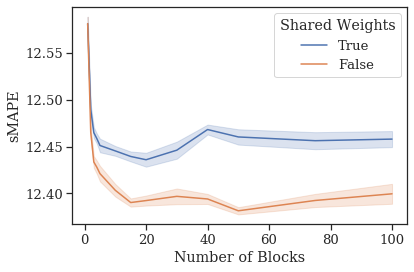

In [4]:
plot_summary(results=m3_bootstrap, 
             result_column='metric', 
             eval_key='Average', 
             metric_name='sMAPE', 
             baseline=None,
             plots_path='/project/experiments/nbeats_meta/plots/M3')

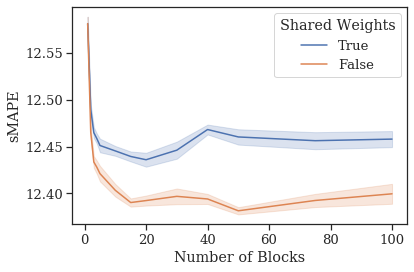

In [5]:
plot_summary(results=m3_bootstrap, 
             result_column='metric', 
             eval_key='Average', 
             metric_name='sMAPE', 
             baseline=None,
             plots_path=None)

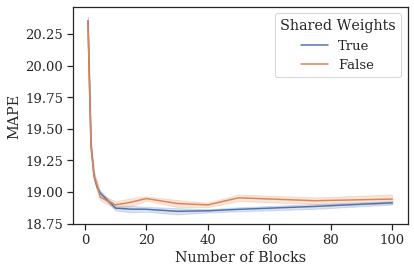

In [6]:
plot_summary(results=tourism_bootstrap, 
             result_column='metric', 
             eval_key='Average', 
             metric_name='MAPE', 
             baseline=None,
             plots_path='/project/experiments/nbeats_meta/plots/tourism')

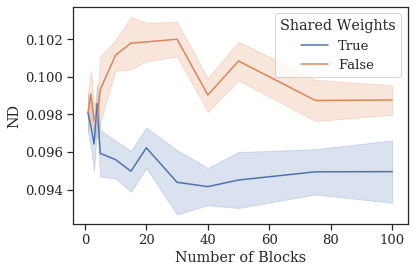

In [7]:
plot_summary(results=electricity_bootstrap, 
             result_column='metric', 
             eval_key='metric', 
             metric_name='ND', 
             baseline=None,
             plots_path='/project/experiments/nbeats_meta/plots/electricity')

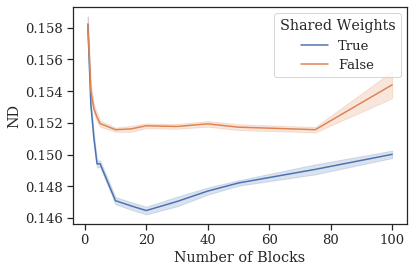

In [8]:
plot_summary(results=traffic_bootstrap, 
             result_column='metric', 
             eval_key='metric', 
             metric_name='ND', 
             baseline=None,
             plots_path='/project/experiments/nbeats_meta/plots/traffic')

In [ ]:
s_experiment_path = '/project/experiments/nbeats_meta/shared_grid_512'
ns_experiment_path = '/project/experiments/nbeats_meta/not_shared_grid_512'

# M3
smape_2_m3_s_bootstrap = collect_statistics(f'{s_experiment_path}/**/M3.csv', M3Statistics(smape_1=False))
smape_2_m3_ns_bootstrap = collect_statistics(f'{ns_experiment_path}/**/M3.csv', M3Statistics(smape_1=False))
smape_2_m3_bootstrap = pd.concat([smape_2_m3_s_bootstrap, smape_2_m3_ns_bootstrap])

# Tourism
smape_2_tourism_s_bootstrap = collect_statistics(f'{s_experiment_path}/**/tourism.csv', TourismStatistics(metric_fn=smape_2))
smape_2_tourism_ns_bootstrap = collect_statistics(f'{ns_experiment_path}/**/tourism.csv', TourismStatistics(metric_fn=smape_2))
smape_2_tourism_bootstrap = pd.concat([smape_2_tourism_s_bootstrap, smape_2_tourism_ns_bootstrap])

# Electricity
smape_2_electricity_s_bootstrap = collect_statistics(f'{s_experiment_path}/**/electricity_deepar.csv', 
                                                     ElectricityStatistics(metric_fn=lambda x, y: np.mean(smape_2(x, y))))
smape_2_electricity_ns_bootstrap = collect_statistics(f'{ns_experiment_path}/**/electricity_deepar.csv', 
                                                      ElectricityStatistics(metric_fn=lambda x, y: np.mean(smape_2(x, y))))
smape_2_electricity_bootstrap = pd.concat([smape_2_electricity_s_bootstrap, smape_2_electricity_ns_bootstrap])

# Traffic
smape_2_traffic_s_bootstrap = collect_statistics(f'{s_experiment_path}/**/traffic_deepar.csv', 
                                         TrafficStatistics(metric_fn=lambda x, y: np.mean(smape_2(x, y))))
smape_2_traffic_ns_bootstrap = collect_statistics(f'{ns_experiment_path}/**/traffic_deepar.csv', 
                                          TrafficStatistics(metric_fn=lambda x, y: np.mean(smape_2(x, y))))
smape_2_traffic_bootstrap = pd.concat([smape_2_traffic_s_bootstrap, smape_2_traffic_ns_bootstrap])

 62%|██████▏   | 8/13 [05:17<03:17, 39.46s/it]

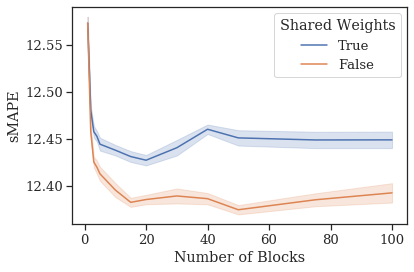

In [11]:
plot_summary(results=smape_2_m3_bootstrap, 
             result_column='metric', 
             eval_key='Average', 
             metric_name='sMAPE', 
             baseline=None,
             plots_path='/project/experiments/nbeats_meta/plots/smape2_M3')

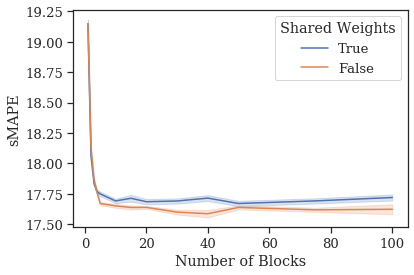

In [12]:
plot_summary(results=smape_2_tourism_bootstrap, 
             result_column='metric', 
             eval_key='Average', 
             metric_name='sMAPE', 
             baseline=None,
             plots_path='/project/experiments/nbeats_meta/plots/smape2_tourism')

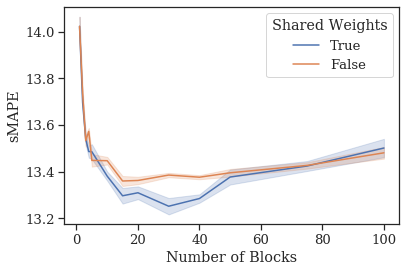

In [13]:
plot_summary(results=smape_2_electricity_bootstrap, 
             result_column='metric', 
             eval_key='metric', 
             metric_name='sMAPE', 
             baseline=None,
             plots_path='/project/experiments/nbeats_meta/plots/smape2_electricity')

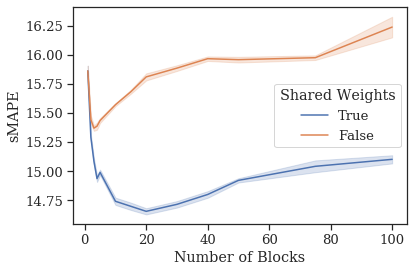

In [14]:
plot_summary(results=smape_2_traffic_bootstrap, 
             result_column='metric', 
             eval_key='metric', 
             metric_name='sMAPE', 
             baseline=None,
             plots_path='/project/experiments/nbeats_meta/plots/smape2_traffic')